In [10]:
import numpy as np
import pandas as pd
import skfuzzy as fuzz
import skfuzzy.control as ctrl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import pickle

In [11]:
# Load dataset
data = pd.read_csv("indiancrop_dataset.csv")
data

,N_SOIL,P_SOIL,K_SOIL,TEMPERATURE,HUMIDITY,ph,RAINFALL,STATE,CROP_PRICE,CROP
0,90,42,43,20.879744,82.002744,6.502985,202.935536,Andaman and Nicobar,7000,Rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,Andaman and Nicobar,5000,Rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,Andaman and Nicobar,7000,Rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,Andaman and Nicobar,7000,Rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,Andaman and Nicobar,120000,Rice
...,...,...,...,...,...,...,...,...,...,...
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,West Bengal,1000,Coffee
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,West Bengal,800,Coffee
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,West Bengal,560,Coffee
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,West Bengal,1500,Coffee


In [12]:
# Encode categorical variables
label_encoder_state = LabelEncoder()
label_encoder_crop = LabelEncoder()
data['STATE'] = label_encoder_state.fit_transform(data['STATE'])
data['CROP'] = label_encoder_crop.fit_transform(data['CROP'])
label_encoder_state.classes_
label_encoder_crop.classes_

array(['Apple', 'Banana', 'Blackgram', 'ChickPea', 'Coconut', 'Coffee',
       'Cotton', 'Grapes', 'Jute', 'KidneyBeans', 'Lentil', 'Maize',
       'Mango', 'MothBeans', 'MungBean', 'Muskmelon', 'Orange', 'Papaya',
       'PigeonPeas', 'Pomegranate', 'Rice', 'Watermelon'], dtype=object)

In [14]:
# Define fuzzy input variables
nitrogen = ctrl.Antecedent(np.arange(0, 151, 1), 'Nitrogen')
phosphorus = ctrl.Antecedent(np.arange(0, 151, 1), 'Phosphorus')
potassium = ctrl.Antecedent(np.arange(0, 151, 1), 'Potassium')
ph = ctrl.Antecedent(np.arange(3, 10, 0.1), 'pH')
temperature = ctrl.Antecedent(np.arange(0, 51, 1), 'Temperature')
moisture = ctrl.Antecedent(np.arange(0, 101, 1), 'Moisture')

In [15]:
# Define fuzzy output variable
crop_output = ctrl.Consequent(np.arange(0, 11, 1), 'Crop_Suitability_Index')

In [16]:
# Membership functions for input variables
for feature in [nitrogen, phosphorus, potassium, ph, temperature, moisture]:
    feature.automf(3)

In [17]:
# Membership functions for output
crop_output['low'] = fuzz.trimf(crop_output.universe, [0, 0, 5])
crop_output['medium'] = fuzz.trimf(crop_output.universe, [3, 5, 8])
crop_output['high'] = fuzz.trimf(crop_output.universe, [6, 10, 10])

In [18]:
# Define fuzzy rules
rules = [
    ctrl.Rule(nitrogen['poor'] | phosphorus['poor'] | potassium['poor'], crop_output['low']),
    ctrl.Rule(nitrogen['average'] & phosphorus['average'] & potassium['average'], crop_output['medium']),
    ctrl.Rule(nitrogen['good'] & phosphorus['good'] & potassium['good'], crop_output['high']),
    ctrl.Rule(ph['poor'], crop_output['low']),
    ctrl.Rule(temperature['good'] & moisture['good'], crop_output['high']),
    ctrl.Rule(temperature['poor'] | moisture['poor'], crop_output['low']),
    ctrl.Rule(ph['good'] & temperature['good'], crop_output['high']),
    ctrl.Rule(nitrogen['average'] & moisture['average'], crop_output['medium'])
]


In [19]:
# Control system
crop_ctrl = ctrl.ControlSystem(rules)
crop_simulation = ctrl.ControlSystemSimulation(crop_ctrl)

In [21]:
# Compute fuzzy output
data['Crop_Suitability_Index'] = 0.0  # Set float dtype

for i in range(len(data)):
    crop_simulation.input['Nitrogen'] = data.loc[i, 'N_SOIL']
    crop_simulation.input['Phosphorus'] = data.loc[i, 'P_SOIL']
    crop_simulation.input['Potassium'] = data.loc[i, 'K_SOIL']
    crop_simulation.input['pH'] = data.loc[i, 'ph']
    crop_simulation.input['Temperature'] = data.loc[i, 'TEMPERATURE']
    crop_simulation.input['Moisture'] = data.loc[i, 'HUMIDITY']

    crop_simulation.compute()

    data.loc[i, 'Crop_Suitability_Index'] = float(crop_simulation.output['Crop_Suitability_Index'])


In [22]:
# Machine Learning Approach
X = data.drop(['CROP'], axis=1)
y = data['CROP']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2, test_size=0.2)

In [23]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [24]:
# Models with adjusted hyperparameters
models = {
    "Logistic Regression": LogisticRegression(max_iter=200, C=0.1),
    "Random Forest": RandomForestClassifier(n_estimators=10, max_depth=3, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=100, weights='uniform'),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=10, learning_rate=0.02, max_depth=2),
    "Decision Tree": DecisionTreeClassifier(max_depth=3, random_state=42)
}

In [25]:
# Train and evaluate models
accuracies = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracies[name] = accuracy_score(y_test, y_pred) * 100
    print(f'Accuracy ({name}): {accuracies[name]:.2f}%')

Accuracy (Logistic Regression): 87.05%
Accuracy (Random Forest): 83.18%
Accuracy (KNN): 88.64%
Accuracy (Gradient Boosting): 92.95%
Accuracy (Decision Tree): 22.05%


In [26]:
y_pred

array([21, 21, 21, 21, 21, 21, 21, 21, 21, 21,  3, 21, 21, 21, 21, 20, 21,
       21, 21, 21, 21,  9, 21, 21, 21,  9, 21, 21, 21, 21, 21,  3, 21, 21,
       21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,  3, 21,
       21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,  7, 21,  7,  7, 21,
       21, 20,  0, 21,  3, 21, 21, 20, 21, 21, 21, 21, 21, 21, 20, 21, 21,
       21, 21, 20, 20, 21, 20, 21, 21, 21, 21, 21, 21, 20, 21, 21, 21,  0,
       21, 21, 21, 21, 20, 21, 21, 21, 21,  3, 21, 21,  0,  9,  3, 21, 21,
       21, 21, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 20, 21,  3, 21,
       21, 21, 20, 21, 21, 21,  0, 21, 21, 21, 20, 21, 21, 21, 21, 21, 21,
       21,  7, 21, 21, 21, 21, 21,  3, 21, 21, 21, 21, 20, 21, 21, 21,  7,
       21, 21,  3, 21,  9, 21,  9, 21,  7, 21, 21, 21, 21, 21, 21,  7, 21,
       21, 20, 21,  7, 21, 21, 21, 21, 21,  0, 21, 21, 21, 21, 21,  0, 21,
       21, 21, 21, 20,  9, 21,  0, 20,  3, 21, 21, 21, 21, 21,  0, 20, 21,
       21, 21, 21, 21, 21

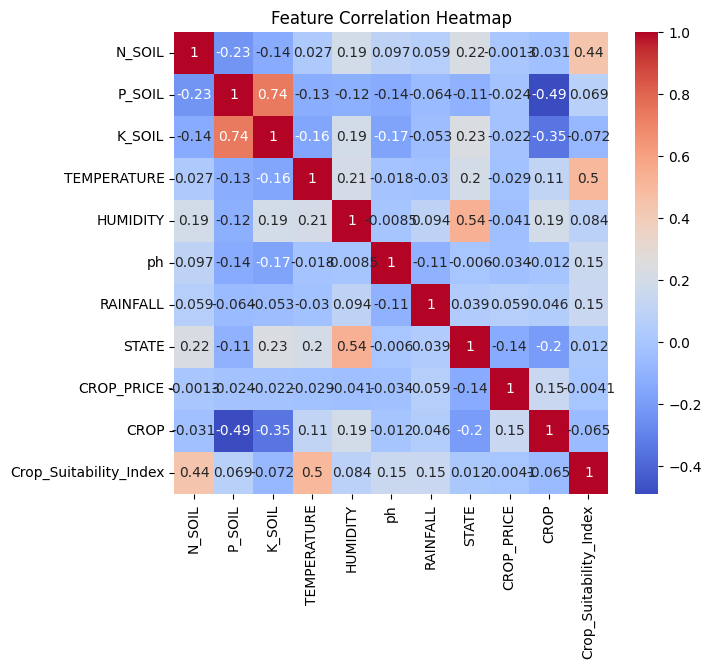

In [27]:
# Visualization
plt.figure(figsize=(7, 6))
sns.heatmap(data.corr(), cmap="coolwarm", annot=True)
plt.title("Feature Correlation Heatmap")
plt.show()

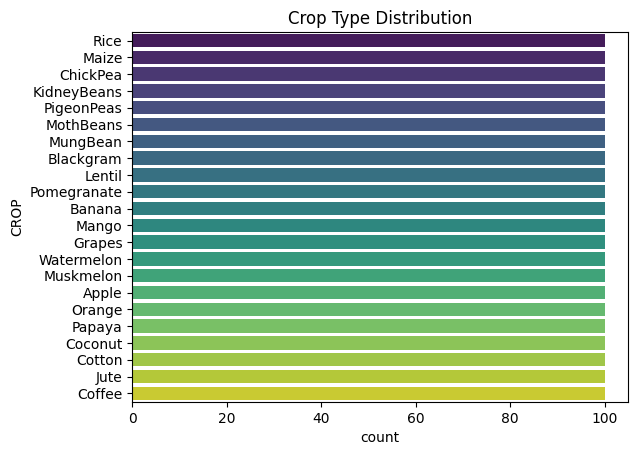

In [29]:
sns.countplot(y='CROP', data=data, hue="CROP", palette="viridis", legend=False)
plt.title("Crop Type Distribution")
plt.show()

In [33]:
state_mapping = dict(enumerate(label_encoder_state.classes_))
crop_mapping = dict(enumerate(label_encoder_crop.classes_))

data['STATE'] = data['STATE'].map(state_mapping)
data['CROP'] = data['CROP'].map(crop_mapping)

data.to_csv("indiancrop_dataset.csv", index=False)

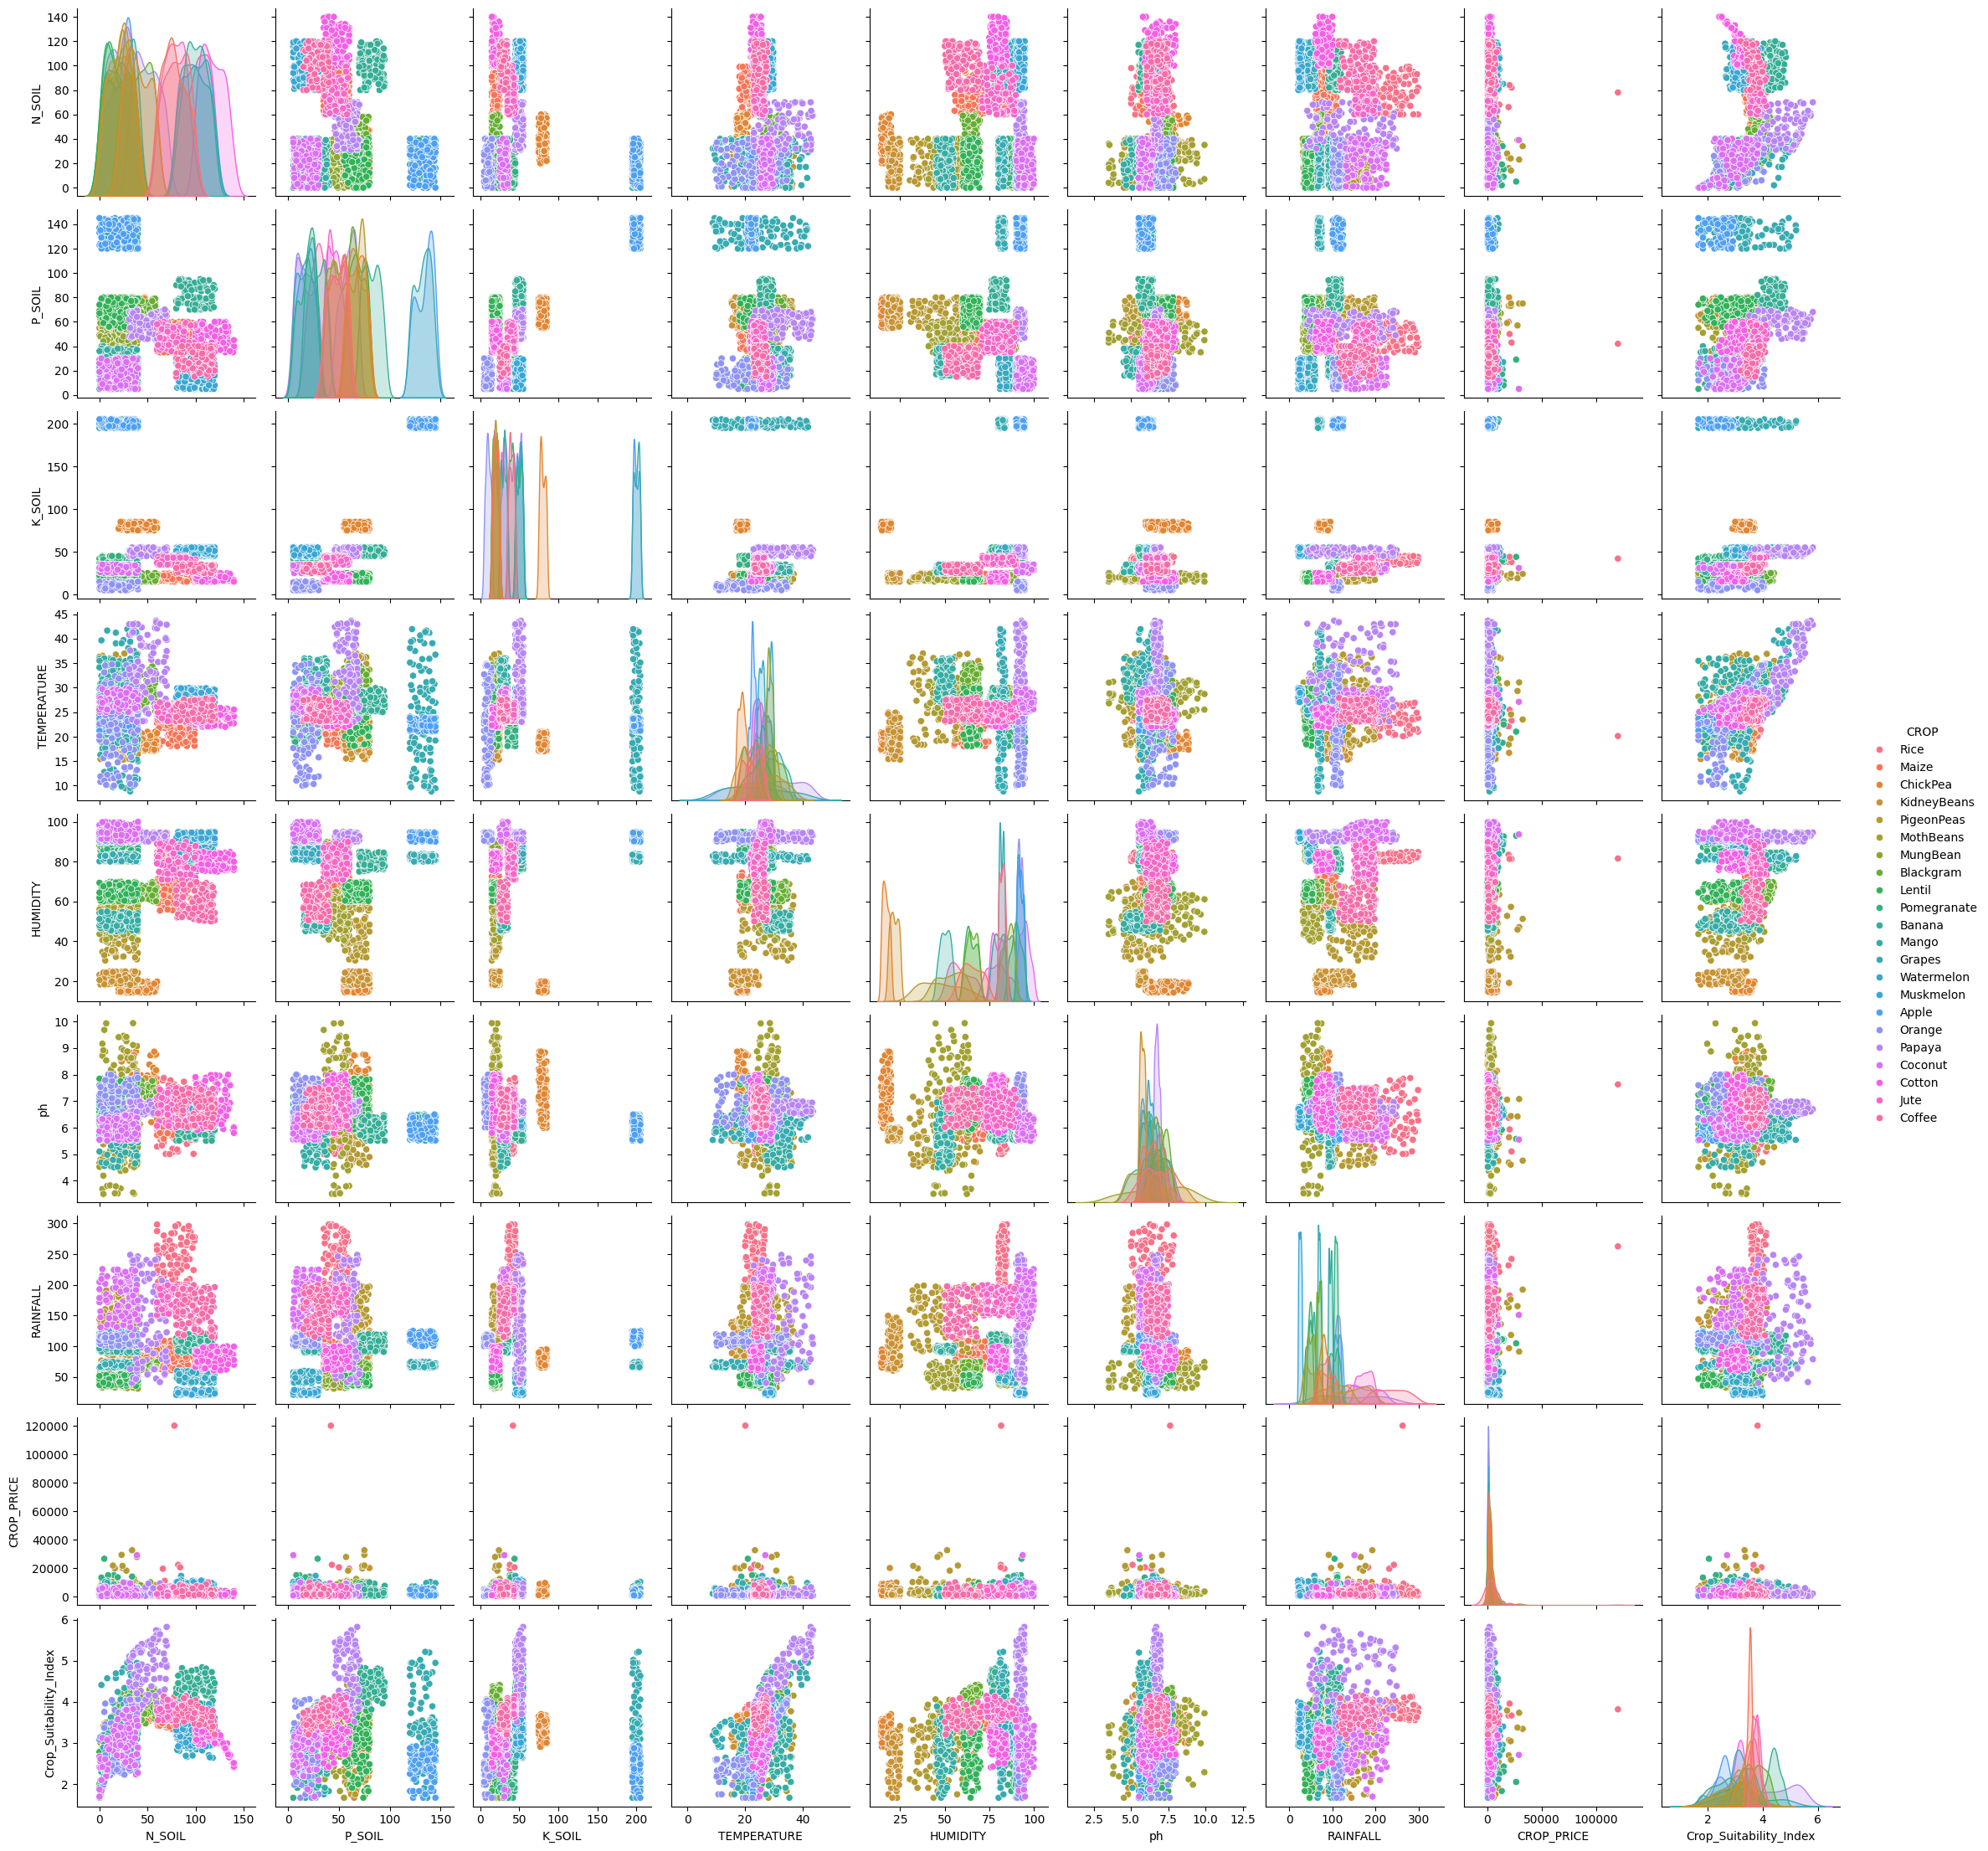

In [41]:
sns.pairplot(data, hue='CROP')
plt.show()